<a href="https://colab.research.google.com/github/dhanushpachabhatla/My_LangChain_Playground/blob/main/langchain_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langchain_community langchain langsmith langchain_google_genai --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.0/444.0 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


# LangChain Agent Executor

When we talk about agents, a significant part of an "agent" is simple code logic,
iteratively rerunning LLM calls and processing their output. The exact logic varies
significantly, but one well-known example is the **ReAct** agent.

![ReAct process](https://www.aurelio.ai/_next/image?url=%2Fimages%2Fposts%2Fai-agents%2Fai-agents-00.png&w=640&q=75)

**Re**ason + **Act**ion (ReAct) agents use iterative _reasoning_ and _action_ steps to
incorporate chain-of-thought and tool-use into their execution. During the _reasoning_
step, the LLM generates the steps to take to answer the query. Next, the LLM generates
the _action_ input, which our code logic parses into a tool call.

![Agentic graph of ReAct](https://www.aurelio.ai/_next/image?url=%2Fimages%2Fposts%2Fai-agents%2Fai-agents-01.png&w=640&q=75)

Following our action step, we get an observation from the tool call. Then, we feed the
observation back into the agent executor logic for a final answer or further reasoning
and action steps.

The agent and agent executor we will be building will follow this pattern.

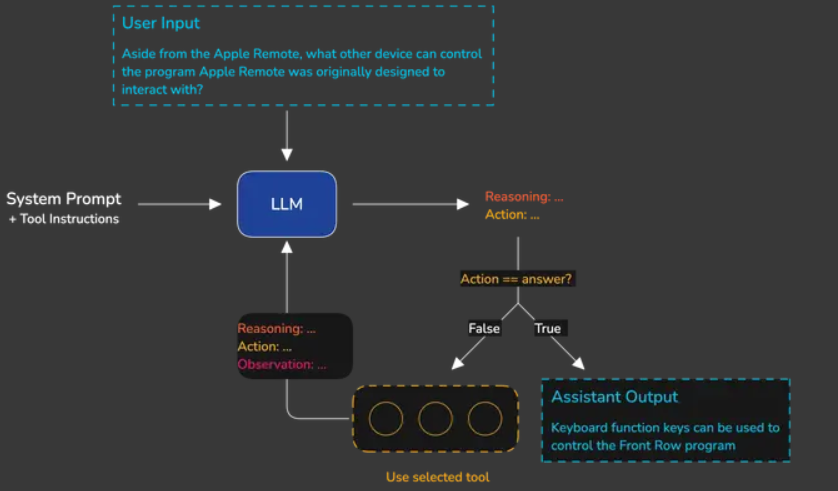

In [2]:
import os
from getpass import getpass

os.environ["LANGCHAIN_API_KEY"] = getpass("Enter LangSmith API Key: ")

# below should not be changed
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
# you can change this as preferred
os.environ["LANGCHAIN_PROJECT"] = "pr-husky-bran-20"

Enter LangSmith API Key: ··········


In [3]:
import os
from getpass import getpass
from langchain_google_genai import ChatGoogleGenerativeAI

os.environ['GOOGLE_API_KEY'] = getpass("Enter your GEMINI KEY")

llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash',temperature= 0.2)

Enter your GEMINI KEY··········


In [11]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnablePassthrough, RunnableMap
from langchain_core.output_parsers import StrOutputParser
from langchain.memory import ConversationBufferMemory
from langchain.agents import tool, AgentExecutor

In [18]:
from langchain_core.tools import tool

@tool
def add(x: float, y: float) -> float:
    """Add 'x' and 'y'."""
    return x + y

# Define the multiply tool
@tool
def multiply(x: float, y: float) -> float:
    """Multiply 'x' and 'y'."""
    return x * y

# Define the exponentiate tool
@tool
def exponentiate(x: float, y: float) -> float:
    """Raise 'x' to the power of 'y'."""
    return x ** y

@tool
def subtract(x: float, y: float) -> float:
    """Subtract 'x' from 'y'."""
    return y - x

In [19]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages([
    ("system", (
        "You're a helpful assistant. When answering a user's question "
        "you should first use one of the tools provided. After using a "
        "tool the tool output will be provided in the "
        "'scratchpad' below. If you have an answer in the "
        "scratchpad you should not use any more tools and "
        "instead answer directly to the user."
    )),
    MessagesPlaceholder(variable_name="chat_history"),
    ("human", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad"),
])

steps:
1. Prompt definition
2. define `Tools`
3. llm = `llm.bind_tools()`
3. `agent : runnableSerializable -> chain`
4. `agent.invoke`

In [20]:
from langchain_core.runnables.base import RunnableSerializable

tools = [add, subtract, multiply, exponentiate]

# define the agent runnable
agent: RunnableSerializable = (
    {
        "input": lambda x: x["input"],
        "chat_history": lambda x: x["chat_history"],
        "agent_scratchpad": lambda x: x.get("agent_scratchpad", [])
    }
    | prompt
    | llm.bind_tools(tools, tool_choice="any")
)

We invoke the agent with the `invoke` method, passing in the input and chat history.

In [21]:
tool_call = agent.invoke({"input": "What is 10 + 10", "chat_history": []})
tool_call

AIMessage(content='', additional_kwargs={'function_call': {'name': 'add', 'arguments': '{"y": 10.0, "x": 10.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--4df21835-b147-474b-923f-2a4d15f05b16-0', tool_calls=[{'name': 'add', 'args': {'y': 10.0, 'x': 10.0}, 'id': '63f0a37e-6fcd-4f6b-bbb4-b4abebc4dea5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 276, 'output_tokens': 74, 'total_tokens': 350, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 54}})

Because we set `tool_choice="any"` to force the tool output, the usual `content` field will be empty as that field is used for natural language output, ie the _final answer_ of the LLM. To find our tool output, we need to look at the `tool_calls` field: